In [1]:
import os
import sys
import tensorflow
import PIL.Image
from PIL import Image
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Input,Add,MaxPool2D,Flatten,AveragePooling2D,Dense,BatchNormalization,ZeroPadding2D,Activation,Concatenate,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from keras import backend as K

In [3]:



def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    axes = axes.flatten()


    if 'accuracy' in hist and 'val_accuracy' in hist:
        
        training_accuracy = hist['accuracy'][:stop]
        validation_accuracy = hist['val_accuracy'][:stop]

        axes[0].plot(range(len(training_accuracy)), training_accuracy, label='Training', color='#FF533D')
        axes[0].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation', color='#03507E')
        axes[0].set_title('Accuracy')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(loc='lower right')



    plt.tight_layout()
    plt.show()




In [4]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [5]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [6]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples // batch_size)

    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [7]:
def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    
    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    
    model = Sequential()

    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    model.save_weights(top_model_weights_path)  
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f) 
        
    return model, fit.history

In [8]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")
    
    top_model = Sequential()
    
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    top_model.save_weights(top_model_weights_path)  
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    
    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    top_model.save_weights(fine_tuned_model_path)
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history   

In [9]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    predictions = predictions.flatten()
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [15]:
location = 'data2'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
train_data_dir = location+'/Train'
validation_data_dir = location+'/Validate'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 1824
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 448
img_width, img_height = 256,256
epochs = 50
batch_size = 16

In [16]:
save_bottleneck_features()

Found 1824 images belonging to 2 classes.
114/114 [==============================] - 208s 2s/step
Found 448 images belonging to 2 classes.
28/28 [==============================] - 55s 2s/step


In [17]:
d2_model1, d2_history1 = train_top_model()

Epoch 1/50
114/114 [==============================] - ETA: 0s - loss: 1.4872 - accuracy: 0.4940WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 1.4872 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5022
Epoch 2/50
114/114 [==============================] - ETA: 0s - loss: 0.7728 - accuracy: 0.5027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.7728 - accuracy: 0.5027 - val_loss: 0.6930 - val_accuracy: 0.5022
Epoch 3/50
114/114 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.5318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.7217 - accuracy: 0.5318 - val_loss: 0.7003 - val_accuracy: 0.5156
Epoch 4/50
114/114 [==============================] - ETA: 0s - loss: 0.7504 - accuracy: 0.5455WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.7504 - accuracy: 0.5455 - val_loss: 0.7406 - val_accuracy: 0.4844
Epoch 5/50
114/114 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.5537WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.7156 - accuracy: 0.5537 - val_loss: 0.7405 - val_accuracy: 0.5000
Epoch 6/50
114/114 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.5630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.7017 - accuracy: 0.5630 - val_loss: 0.6987 - val_accuracy: 0.5134
Epoch 7/50
114/114 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5894WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 57ms/step - loss: 0.6861 - accuracy: 0.5894 - val_loss: 0.7295 - val_accuracy: 0.5179
Epoch 8/50
114/114 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.6316WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.6589 - accuracy: 0.6316 - val_loss: 0.7320 - val_accuracy: 0.5156
Epoch 9/50
114/114 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.6447WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.6148 - accuracy: 0.6447 - val_loss: 0.7773 - val_accuracy: 0.4844
Epoch 10/50
114/114 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.6760WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.6001 - accuracy: 0.6760 - val_loss: 0.8289 - val_accuracy: 0.5223
Epoch 11/50
114/114 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.6859WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 57ms/step - loss: 0.5806 - accuracy: 0.6859 - val_loss: 0.9319 - val_accuracy: 0.5067
Epoch 12/50
114/114 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.7188WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 57ms/step - loss: 0.5652 - accuracy: 0.7188 - val_loss: 0.8536 - val_accuracy: 0.4933
Epoch 13/50
114/114 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.7456WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 57ms/step - loss: 0.4976 - accuracy: 0.7456 - val_loss: 0.9628 - val_accuracy: 0.5045
Epoch 14/50
114/114 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7248WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 60ms/step - loss: 0.5127 - accuracy: 0.7248 - val_loss: 0.8611 - val_accuracy: 0.5045
Epoch 15/50
114/114 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.7599WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 54ms/step - loss: 0.4553 - accuracy: 0.7599 - val_loss: 1.0838 - val_accuracy: 0.4754
Epoch 16/50
114/114 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.7686WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.4687 - accuracy: 0.7686 - val_loss: 1.1125 - val_accuracy: 0.4799
Epoch 17/50
114/114 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7610WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.4475 - accuracy: 0.7610 - val_loss: 0.9747 - val_accuracy: 0.5067
Epoch 18/50
114/114 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.7966WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 62ms/step - loss: 0.4155 - accuracy: 0.7966 - val_loss: 1.0301 - val_accuracy: 0.4866
Epoch 19/50
114/114 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.7971WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 61ms/step - loss: 0.4345 - accuracy: 0.7971 - val_loss: 1.0094 - val_accuracy: 0.5201
Epoch 20/50
114/114 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.7982WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 66ms/step - loss: 0.4082 - accuracy: 0.7982 - val_loss: 1.1910 - val_accuracy: 0.5246
Epoch 21/50
114/114 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.8273WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 61ms/step - loss: 0.3765 - accuracy: 0.8273 - val_loss: 1.2460 - val_accuracy: 0.4933
Epoch 22/50
114/114 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8196WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.3831 - accuracy: 0.8196 - val_loss: 1.4663 - val_accuracy: 0.4844
Epoch 23/50
114/114 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8350WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.3409 - accuracy: 0.8350 - val_loss: 1.4322 - val_accuracy: 0.5000
Epoch 24/50
114/114 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8427WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.3393 - accuracy: 0.8427 - val_loss: 1.7447 - val_accuracy: 0.4866
Epoch 25/50
114/114 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8492WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 60ms/step - loss: 0.3377 - accuracy: 0.8492 - val_loss: 2.2914 - val_accuracy: 0.5089
Epoch 26/50
114/114 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8553WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.3228 - accuracy: 0.8553 - val_loss: 1.3554 - val_accuracy: 0.4844
Epoch 27/50
114/114 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8525WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.3178 - accuracy: 0.8525 - val_loss: 1.4354 - val_accuracy: 0.5022
Epoch 28/50
114/114 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8739WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.2920 - accuracy: 0.8739 - val_loss: 1.4832 - val_accuracy: 0.5134
Epoch 29/50
114/114 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8745WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 57ms/step - loss: 0.2852 - accuracy: 0.8745 - val_loss: 1.5510 - val_accuracy: 0.4821
Epoch 30/50
114/114 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8799WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.2864 - accuracy: 0.8799 - val_loss: 1.6759 - val_accuracy: 0.4598
Epoch 31/50
114/114 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.8953WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 60ms/step - loss: 0.2520 - accuracy: 0.8953 - val_loss: 2.1485 - val_accuracy: 0.5022
Epoch 32/50
114/114 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.8898WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 53ms/step - loss: 0.2426 - accuracy: 0.8898 - val_loss: 1.8084 - val_accuracy: 0.5022
Epoch 33/50
114/114 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8832WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 53ms/step - loss: 0.2672 - accuracy: 0.8832 - val_loss: 1.8749 - val_accuracy: 0.4821
Epoch 34/50
114/114 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.8947WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 54ms/step - loss: 0.2293 - accuracy: 0.8947 - val_loss: 1.9627 - val_accuracy: 0.4933
Epoch 35/50
114/114 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9046WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.2388 - accuracy: 0.9046 - val_loss: 1.9527 - val_accuracy: 0.4911
Epoch 36/50
114/114 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9035WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 57ms/step - loss: 0.2374 - accuracy: 0.9035 - val_loss: 1.9682 - val_accuracy: 0.4978
Epoch 37/50
114/114 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9057WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 57ms/step - loss: 0.2202 - accuracy: 0.9057 - val_loss: 2.0197 - val_accuracy: 0.4754
Epoch 38/50
114/114 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9046WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.2452 - accuracy: 0.9046 - val_loss: 2.2476 - val_accuracy: 0.4955
Epoch 39/50
114/114 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9090WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.2301 - accuracy: 0.9090 - val_loss: 1.9515 - val_accuracy: 0.5000
Epoch 40/50
114/114 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9172WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.1977 - accuracy: 0.9172 - val_loss: 2.2829 - val_accuracy: 0.4844
Epoch 41/50
114/114 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9062WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.2142 - accuracy: 0.9062 - val_loss: 2.2888 - val_accuracy: 0.4777
Epoch 42/50
114/114 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9106WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 54ms/step - loss: 0.2093 - accuracy: 0.9106 - val_loss: 2.6906 - val_accuracy: 0.5045
Epoch 43/50
114/114 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9156WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 54ms/step - loss: 0.1885 - accuracy: 0.9156 - val_loss: 2.5396 - val_accuracy: 0.4732
Epoch 44/50
114/114 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9183WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.2028 - accuracy: 0.9183 - val_loss: 2.2923 - val_accuracy: 0.4911
Epoch 45/50
114/114 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9353WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 55ms/step - loss: 0.1741 - accuracy: 0.9353 - val_loss: 2.9831 - val_accuracy: 0.4777
Epoch 46/50
114/114 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9243WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 56ms/step - loss: 0.2014 - accuracy: 0.9243 - val_loss: 2.3333 - val_accuracy: 0.4844
Epoch 47/50
114/114 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9397WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 6s 57ms/step - loss: 0.1663 - accuracy: 0.9397 - val_loss: 2.8104 - val_accuracy: 0.4688
Epoch 48/50
114/114 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9337WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.1660 - accuracy: 0.9337 - val_loss: 3.1370 - val_accuracy: 0.4799
Epoch 49/50
114/114 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9243WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.2238 - accuracy: 0.9243 - val_loss: 2.7847 - val_accuracy: 0.5067
Epoch 50/50
114/114 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9452WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 7s 58ms/step - loss: 0.1498 - accuracy: 0.9452 - val_loss: 2.2934 - val_accuracy: 0.4955


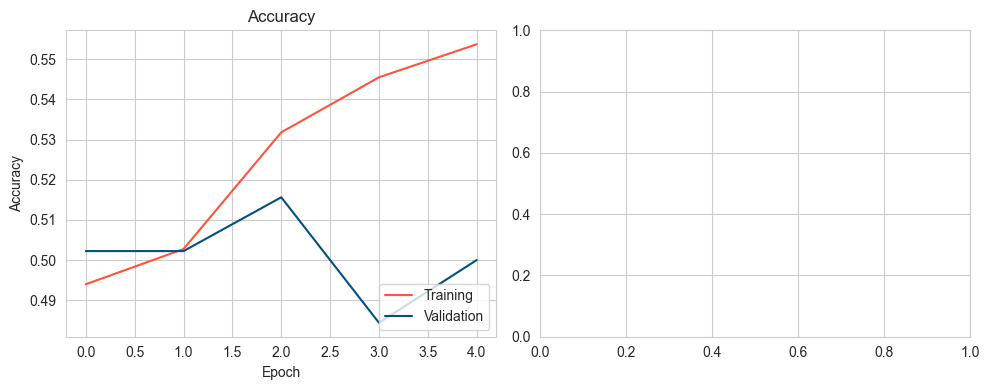

In [18]:

plot_metrics(d2_history1, stop=5)

In [19]:
ft_model, ft_history = finetune_binary_model()

Model loaded.
Found 1824 images belonging to 2 classes.
Found 448 images belonging to 2 classes.
Epoch 1/50
114/114 [==============================] - ETA: 0s - loss: 0.9947 - accuracy: 0.3438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 303s 3s/step - loss: 0.9947 - accuracy: 0.3438 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 2/50
114/114 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.3492WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 299s 3s/step - loss: 0.9852 - accuracy: 0.3492 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 3/50
114/114 [==============================] - ETA: 0s - loss: 0.9698 - accuracy: 0.3640WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 293s 3s/step - loss: 0.9698 - accuracy: 0.3640 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 4/50
114/114 [==============================] - ETA: 0s - loss: 0.9869 - accuracy: 0.3531WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 301s 3s/step - loss: 0.9869 - accuracy: 0.3531 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 5/50
114/114 [==============================] - ETA: 0s - loss: 0.9796 - accuracy: 0.3525WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 298s 3s/step - loss: 0.9796 - accuracy: 0.3525 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 6/50
114/114 [==============================] - ETA: 0s - loss: 1.0136 - accuracy: 0.3586WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 296s 3s/step - loss: 1.0136 - accuracy: 0.3586 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 7/50
114/114 [==============================] - ETA: 0s - loss: 0.9888 - accuracy: 0.3432WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 294s 3s/step - loss: 0.9888 - accuracy: 0.3432 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 8/50
114/114 [==============================] - ETA: 0s - loss: 0.9726 - accuracy: 0.3701WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 285s 3s/step - loss: 0.9726 - accuracy: 0.3701 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 9/50
114/114 [==============================] - ETA: 0s - loss: 0.9717 - accuracy: 0.3514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 299s 3s/step - loss: 0.9717 - accuracy: 0.3514 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 10/50
114/114 [==============================] - ETA: 0s - loss: 0.9731 - accuracy: 0.3575WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 274s 2s/step - loss: 0.9731 - accuracy: 0.3575 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 11/50
114/114 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.3525WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 275s 2s/step - loss: 0.9884 - accuracy: 0.3525 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 12/50
114/114 [==============================] - ETA: 0s - loss: 0.9848 - accuracy: 0.3586WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 270s 2s/step - loss: 0.9848 - accuracy: 0.3586 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 13/50
114/114 [==============================] - ETA: 0s - loss: 0.9959 - accuracy: 0.3542WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 272s 2s/step - loss: 0.9959 - accuracy: 0.3542 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 14/50
114/114 [==============================] - ETA: 0s - loss: 0.9856 - accuracy: 0.3476WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 277s 2s/step - loss: 0.9856 - accuracy: 0.3476 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 15/50
114/114 [==============================] - ETA: 0s - loss: 0.9746 - accuracy: 0.3575WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 278s 2s/step - loss: 0.9746 - accuracy: 0.3575 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 16/50
114/114 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.3525WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 278s 2s/step - loss: 0.9858 - accuracy: 0.3525 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 17/50
114/114 [==============================] - ETA: 0s - loss: 0.9863 - accuracy: 0.3646WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 277s 2s/step - loss: 0.9863 - accuracy: 0.3646 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 18/50
114/114 [==============================] - ETA: 0s - loss: 0.9850 - accuracy: 0.3564WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 276s 2s/step - loss: 0.9850 - accuracy: 0.3564 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 19/50
114/114 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.3602WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 280s 2s/step - loss: 0.9656 - accuracy: 0.3602 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 20/50
114/114 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.3520WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 292s 3s/step - loss: 0.9789 - accuracy: 0.3520 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 21/50
114/114 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.3416WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 271s 2s/step - loss: 1.0090 - accuracy: 0.3416 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 22/50
114/114 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.3684WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 244s 2s/step - loss: 0.9799 - accuracy: 0.3684 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 23/50
114/114 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.3514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 244s 2s/step - loss: 1.0006 - accuracy: 0.3514 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 24/50
114/114 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.3372WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 241s 2s/step - loss: 0.9984 - accuracy: 0.3372 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 25/50
114/114 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.3487WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 238s 2s/step - loss: 0.9870 - accuracy: 0.3487 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 26/50
114/114 [==============================] - ETA: 0s - loss: 0.9955 - accuracy: 0.3405WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 238s 2s/step - loss: 0.9955 - accuracy: 0.3405 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 27/50
114/114 [==============================] - ETA: 0s - loss: 0.9885 - accuracy: 0.3470WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 238s 2s/step - loss: 0.9885 - accuracy: 0.3470 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 28/50
114/114 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.3509WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 246s 2s/step - loss: 0.9903 - accuracy: 0.3509 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 29/50
114/114 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.3575WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 245s 2s/step - loss: 0.9674 - accuracy: 0.3575 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 30/50
114/114 [==============================] - ETA: 0s - loss: 0.9730 - accuracy: 0.3618WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 242s 2s/step - loss: 0.9730 - accuracy: 0.3618 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 31/50
114/114 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.3498WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 242s 2s/step - loss: 1.0037 - accuracy: 0.3498 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 32/50
114/114 [==============================] - ETA: 0s - loss: 0.9970 - accuracy: 0.3410WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 241s 2s/step - loss: 0.9970 - accuracy: 0.3410 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 33/50
114/114 [==============================] - ETA: 0s - loss: 1.0096 - accuracy: 0.3454WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 241s 2s/step - loss: 1.0096 - accuracy: 0.3454 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 34/50
114/114 [==============================] - ETA: 0s - loss: 0.9636 - accuracy: 0.3657WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 251s 2s/step - loss: 0.9636 - accuracy: 0.3657 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 35/50
114/114 [==============================] - ETA: 0s - loss: 1.0058 - accuracy: 0.3383WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 250s 2s/step - loss: 1.0058 - accuracy: 0.3383 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 36/50
114/114 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.3509WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 223s 2s/step - loss: 1.0069 - accuracy: 0.3509 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 37/50
114/114 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.3514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 255s 2s/step - loss: 0.9851 - accuracy: 0.3514 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 38/50
114/114 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.3651WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 264s 2s/step - loss: 0.9910 - accuracy: 0.3651 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 39/50
114/114 [==============================] - ETA: 0s - loss: 0.9994 - accuracy: 0.3377WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 264s 2s/step - loss: 0.9994 - accuracy: 0.3377 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 40/50
114/114 [==============================] - ETA: 0s - loss: 0.9738 - accuracy: 0.3657WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 264s 2s/step - loss: 0.9738 - accuracy: 0.3657 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 41/50
114/114 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.3470WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 264s 2s/step - loss: 0.9945 - accuracy: 0.3470 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 42/50
114/114 [==============================] - ETA: 0s - loss: 0.9935 - accuracy: 0.3438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 264s 2s/step - loss: 0.9935 - accuracy: 0.3438 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 43/50
114/114 [==============================] - ETA: 0s - loss: 0.9675 - accuracy: 0.3684WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 266s 2s/step - loss: 0.9675 - accuracy: 0.3684 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 44/50
114/114 [==============================] - ETA: 0s - loss: 0.9873 - accuracy: 0.3569WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 263s 2s/step - loss: 0.9873 - accuracy: 0.3569 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 45/50
114/114 [==============================] - ETA: 0s - loss: 0.9882 - accuracy: 0.3465WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 265s 2s/step - loss: 0.9882 - accuracy: 0.3465 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 46/50
114/114 [==============================] - ETA: 0s - loss: 1.0023 - accuracy: 0.3481WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 264s 2s/step - loss: 1.0023 - accuracy: 0.3481 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 47/50
114/114 [==============================] - ETA: 0s - loss: 0.9995 - accuracy: 0.3465WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 263s 2s/step - loss: 0.9995 - accuracy: 0.3465 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 48/50
114/114 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.3547WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 266s 2s/step - loss: 0.9862 - accuracy: 0.3547 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 49/50
114/114 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.3498WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 263s 2s/step - loss: 1.0034 - accuracy: 0.3498 - val_loss: 0.9078 - val_accuracy: 0.1339
Epoch 50/50
114/114 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.3706WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 273s 2s/step - loss: 0.9620 - accuracy: 0.3706 - val_loss: 0.9078 - val_accuracy: 0.1339


In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
ft_model = Sequential()
ft_model.add(Flatten(input_shape=base_model.output_shape[1:]))
ft_model.add(Dense(256, activation='relu'))
ft_model.add(Dropout(0.5))
ft_model.add(Dense(1, activation='sigmoid'))
    
ft_model.load_weights(location+'/ft_model.h5')

In [21]:
with open('data2/ft_history.txt') as f:    
    ft_history = json.load(f)

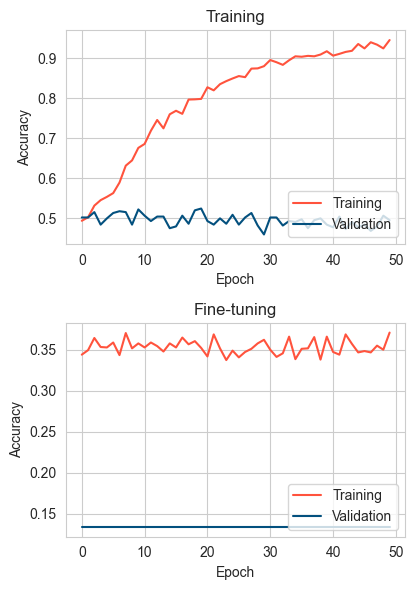

In [23]:
plot_acc_metrics(d2_history1, ft_history, stop=50)


In [24]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [25]:
def pipe2(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256, 256))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

  
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    
    model.load_weights(location+'/ft_model.h5', by_name=True)

    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    
    if pred[0][0] <= 0.5:
        print("Validation complete - proceed to location and severity determination")
    else:
        print("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print("Hint: Try zooming in/out, using a different angle or different lighting")


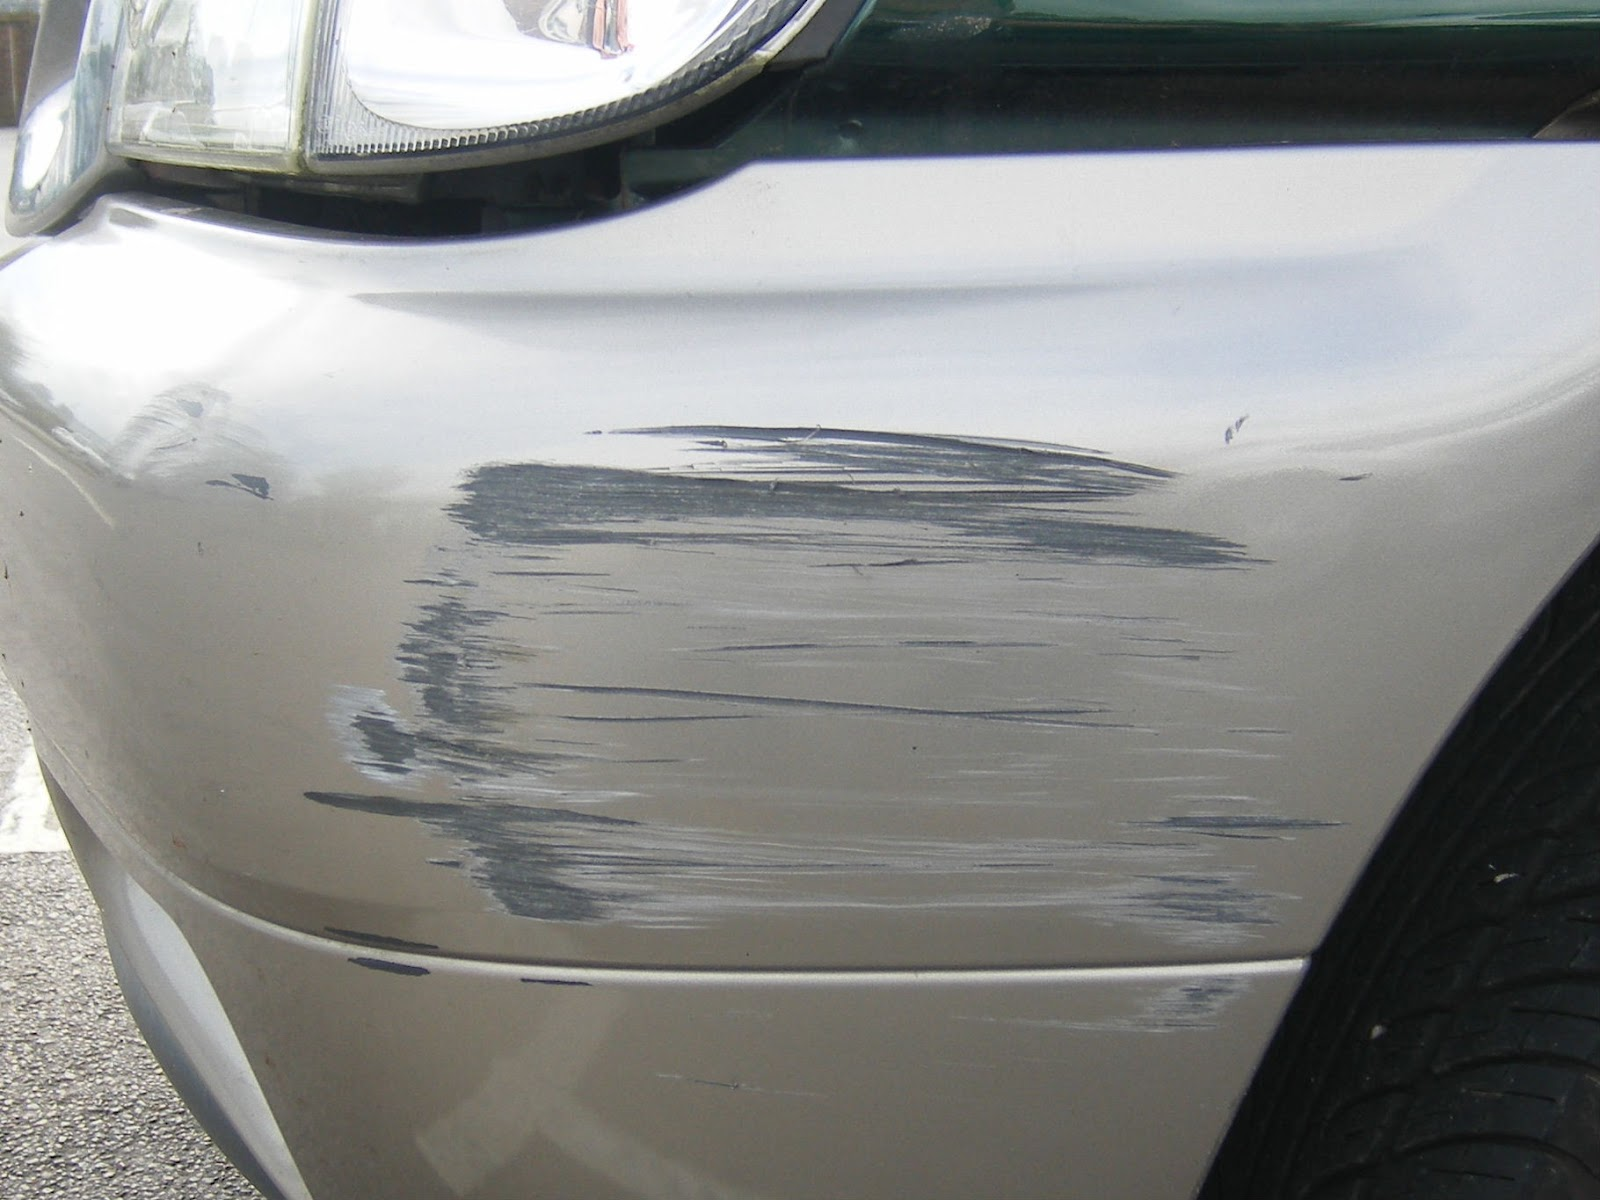

In [26]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

In [27]:
pipe2('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', ft_model)

1/1 [==============================] - 0s 196ms/step
Validating that damage exists....
[[3.7085829e-06]]
Validation complete - proceed to location and severity determination
